In [1]:
# Import Libraries and Dependencies
import matrix_games
from matrix_games.base import*
from matrix_games.generate import*

In [22]:
dimN = 200
dimM = 2000
q0 = np.ones(dimN + dimM)

A = create_A("rand", (dimN,dimM))
prob = mg_problem(A, "fmax")
F_mg, J_mg, _, prox_g_mg = prob.get_parameters()
print(prob)
print(F_mg(q0))

Matrix A: [[0.25038764 0.28210671 0.41508258 ... 0.3224084  0.40385176 0.24499807]
 [0.28590996 0.29260458 0.07801311 ... 0.57556566 0.57947335 0.16428224]
 [0.82018962 0.83010153 0.94017361 ... 0.52205209 0.49577839 0.61473733]
 ...
 [0.36191039 0.8120726  0.52338168 ... 0.29612989 0.50250169 0.29775209]
 [0.83857069 0.89077283 0.76393922 ... 0.2450653  0.59371099 0.43697244]
 [0.19317078 0.60434856 0.50543577 ... 0.35726031 0.4471339  0.50662648]]
 Matrix F: [[ 0.          0.          0.         ...  0.36191039  0.83857069
   0.19317078]
 [ 0.          0.          0.         ...  0.8120726   0.89077283
   0.60434856]
 [ 0.          0.          0.         ...  0.52338168  0.76393922
   0.50543577]
 ...
 [-0.36191039 -0.8120726  -0.52338168 ...  0.          0.
   0.        ]
 [-0.83857069 -0.89077283 -0.76393922 ...  0.          0.
   0.        ]
 [-0.19317078 -0.60434856 -0.50543577 ...  0.          0.
   0.        ]]
 Proximal Operator: [1. 1. 1. ... 1. 1. 1.]
 Simplex?: False
 J Ope

Adaptive Graal Implemntation

In [23]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    diff = [0]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)
        if output:
            #print("F: ", Fx1, "\n")
            print("x: ", x1, "\n")
            print("sum: ", sum(x1), "\n")
            print("x>=0: ", np.any((x1 >= 0)))
            #print("prox: ", prox_g(x_ - la * Fx, la), "\n")

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        #if output:
            #print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        #if i%50 == 0: 
            #print("x at iteration ", i , ": ", x)
        temp = values[-1]
        values.append(J(x))
        diff.append(np.absolute(temp - values[-1]))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list, diff

Solving the VI

In [24]:
N = 200

# starting point
q0 = np.ones(dimN + dimM)

In [25]:
show_out = False
ans1 = adaptive_graal(J_mg, F_mg, prox_g_mg, q0, numb_iter=N, phi=1.5, output=show_out)

CPU time for aGRAAL: 0.4830699000000003


In [26]:
if show_out:
    print("J(x): " , ans1[0][-1])
    print("x: " ,ans1[1])
    print("diff: ", ans1[4])

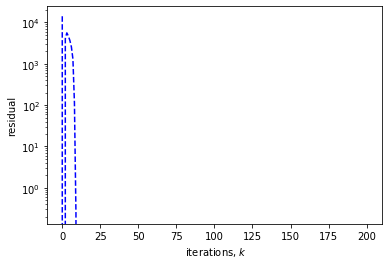

In [27]:
plt.plot(ans1[0], '--b')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()

In [21]:
print(ans1[0])

[4479.154129758019, 0.0, 1174.9191211098178, 1614.1577886562714, 1272.589010022664, 893.0281875713113, 471.32854565207236, 17.34532970087439, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0